# Task 1: Knowledge Graphs
## 1.3 FB15k-237

#### 1.3.0 Install and import libraries

In [ ]:
import torch
import os
os.environ['TORCH'] = torch.__version__
print(torch.__version__)

!pip install -q torch-scatter -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q torch-sparse -f https://data.pyg.org/whl/torch-${TORCH}.html
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git
!pip install info-nce-pytorch

2.1.0+cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 82.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 40.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch_geometric
from torch_geometric.nn import GAE
import torch_geometric.nn as pyg_nn
import matplotlib.pyplot as plt
import torch.nn.init as init

#### 1.3.1 Data exploration and baselines

*a. Data exploration*

Explore the data:

In [ ]:
from torch_geometric.datasets import FB15k_237

dataset = FB15k_237("data/FB15k")
data = dataset[0]
print(f'Dataset: {dataset}')
print(f'Data: {data}\n')

print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
# print(f'Number of features: {dataset.num_features}')
# print(f'Number of relations: {dataset.num_relations}')
print(f'Average node degree: {(data.num_edges) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.has_isolated_nodes()}')
print(f'Contains self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}\n')

train_data = FB15k_237("data/FB15k", split='train')[0]
val_data = FB15k_237("data/FB15k", split='val')[0]
test_data = FB15k_237("data/FB15k", split='test')[0]
print(f'Training data: {train_data}')
print(f'Validation data: {val_data}')
print(f'Test data: {test_data}')

Processing...
Done!


Dataset: FB15k_237()
Data: Data(edge_index=[2, 272115], edge_type=[272115], num_nodes=14541)

Number of nodes: 14541
Number of edges: 272115
Average node degree: 18.71
Contains isolated nodes: True
Contains self-loops: True
Is undirected: False

Training data: Data(edge_index=[2, 272115], edge_type=[272115], num_nodes=14541)
Validation data: Data(edge_index=[2, 17535], edge_type=[17535], num_nodes=14541)
Test data: Data(edge_index=[2, 20466], edge_type=[20466], num_nodes=14541)


In [ ]:
dataset.num_relations = torch.amax(data.edge_type) + 1

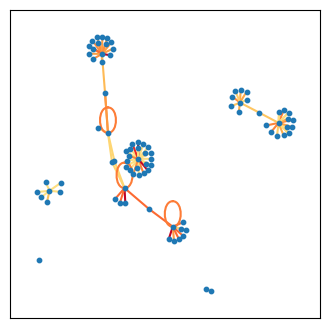

In [ ]:
import networkx as nx
import random
random.seed(42)
# Choose nodes for visualization
nodes = random.sample(range(14541), 10)
edgelist = []
typelist = []

# Ues NetworkX
G = nx.Graph()
for node in nodes:
    neighbors = data.edge_index[0, (data.edge_index[1] == node)].numpy()
    G.add_node(node)
    for neighbor in neighbors:
        G.add_node(neighbor)
        G.add_edge(neighbor, node)
        edgelist.append((neighbor, node))
        type = data.edge_type[torch.logical_and(data.edge_index[0] == neighbor, data.edge_index[1] == node)].numpy()
        typelist.append(type[0])

# Scale edge type values
scale_min, scale_max = 0.2, 1.0
colorlist = (scale_max - scale_min) / (np.max(typelist) - np.min(typelist)) * (typelist - np.min(typelist)) + scale_min

# Plot
fig, ax = plt.subplots(figsize=(4,4))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, ax=ax, nodelist=list(G), node_size=10)
nx.draw_networkx_edges(G, pos, edgelist=edgelist, edge_color=colorlist, edge_cmap=plt.cm.YlOrRd,
                        width=1.5, ax=ax, edge_vmin=0, edge_vmax=1)
plt.savefig('10-node-subgraph-1.3.png', dpi=300, bbox_inches='tight')

*b. Random baseline*

In [ ]:
def eval_random_metrics(eval_data, k=10):
    head_idx, rel_type, tail_idx = eval_data.edge_index[0], eval_data.edge_type, eval_data.edge_index[1]

    reciprocal_ranks, hits_at_k = [], []
    for i in range(rel_type.shape[0]):
        rank = torch.randint(0, rel_type.shape[0], size=(1,))
        reciprocal_ranks.append(1 / (rank + 1))
        hits_at_k.append(rank < k)

    mrr = float(torch.tensor(reciprocal_ranks, dtype=torch.float).mean())
    hits_at_k = int(torch.tensor(hits_at_k).sum()) / len(hits_at_k)
    return mrr, hits_at_k

def use_random():
    # test
    mrr, hits_at_k = eval_random_metrics(test_data)
    return mrr, hits_at_k

num_runs = 3
mrr_list = []
hits_at_k_list = []
for run in range(num_runs):
    print("### Run: {}".format(run + 1))
    mrr, hits_at_k = use_random()
    mrr_list.append(mrr)
    hits_at_k_list.append(hits_at_k)
print("Model: Random")
print("Test MRR:\tMean: {}\tStandard deviation: {}".format(np.mean(mrr_list), np.std(mrr_list)))
print("Test H@10:\tMean: {}\tStandard deviation: {}".format(np.mean(hits_at_k_list), np.std(hits_at_k_list)))

### Run: 1
### Run: 2
### Run: 3
Model: Random
Test MRR:	Mean: 0.0005276817052314678	Standard deviation: 2.8745697146413585e-05
Test H@10:	Mean: 0.0004886152643408581	Standard deviation: 6.910063336133565e-05


*c. Feature baseline*   
Feature: (head, relation, tail)   ->   Prediction: a 0~1 score   
Label: 1 for positive edges, 0 for negative edges

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self):
        super(MLPPredictor, self).__init__()
        self.scores = nn.Linear(3, 1)

    def forward(self, x):
        return F.sigmoid(self.scores(x))

    @torch.no_grad()
    def eval_metrics(self, eval_data, k=10):
        head_idx, rel_type, tail_idx = eval_data.edge_index[0].to("cuda"), eval_data.edge_type.to("cuda"), eval_data.edge_index[1].to("cuda")

        reciprocal_ranks, hits_at_k = [], []
        for i in range(rel_type.shape[0]):
            h, r, t = head_idx[i].to(dtype=torch.float32), rel_type[i].to(dtype=torch.float32), tail_idx[i].to(dtype=torch.float32)
            all_tails = torch.arange(data.num_nodes, device="cuda")
            scores = self(torch.stack([h.expand_as(all_tails), r.expand_as(all_tails), all_tails], dim=0).T).view(-1)
            rank = int((scores.argsort(descending=True) == t).nonzero().view(-1))
            reciprocal_ranks.append(1 / (rank + 1))
            hits_at_k.append(rank < k)

        mrr = float(torch.tensor(reciprocal_ranks, dtype=torch.float).mean())
        hits_at_k = int(torch.tensor(hits_at_k).sum()) / len(hits_at_k)
        return mrr, hits_at_k

# negative sampling
def process_data(train_data):
    train_data = train_data.to("cuda")
    mask_1 = torch.rand(train_data.edge_index.size(1)) < 0.5
    mask_2 = ~mask_1

    neg_edge_index = train_data.edge_index.clone()
    neg_edge_index[0, mask_1] = torch.randint(train_data.num_nodes, (mask_1.sum(),), device=neg_edge_index.device)
    neg_edge_index[1, mask_2] = torch.randint(train_data.num_nodes, (mask_2.sum(),), device=neg_edge_index.device)
    return train_data.edge_index, neg_edge_index

def use_mlp(seed):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    mlp_model = MLPPredictor().to("cuda")
    optimizer = torch.optim.Adam(mlp_model.parameters(), lr=0.01, weight_decay=5e-4)

    # train
    for epoch in range(100):
        mlp_model.train()

        # data
        pos_edge_index, neg_edge_index = process_data(train_data)

        # loss
        pos_feature = torch.stack([pos_edge_index[0], train_data.edge_type, pos_edge_index[1]], dim=0).to(dtype=torch.float32).T
        neg_feature = torch.stack([neg_edge_index[0], train_data.edge_type, neg_edge_index[1]], dim=0).to(dtype=torch.float32).T
        pos_edge_pred = mlp_model(pos_feature)
        neg_edge_pred = mlp_model(neg_feature)
        pred = torch.cat([pos_edge_pred, neg_edge_pred], dim=1)
        label = torch.cat([torch.ones_like(pos_edge_pred), torch.zeros_like(neg_edge_pred)], dim=1)
        loss = F.binary_cross_entropy(pred, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # valid
        if (epoch + 1) % 20 == 0:
            mlp_model.eval()
            mrr, hits_at_k = mlp_model.eval_metrics(val_data)
            print("Epoch: {}\tValidation MRR: {:.4f}\tH@10: {:.4f}".format(epoch + 1, mrr, hits_at_k))

    # test
    mlp_model.eval()
    mrr, hits_at_k = mlp_model.eval_metrics(test_data)
    return mrr, hits_at_k

seed_list = [0, 10388, 19260817]
num_runs = len(seed_list)
mrr_list = []
hits_at_k_list = []
for run in range(num_runs):
    print("### Run: {}".format(run + 1))
    mrr, hits_at_k = use_mlp(seed=seed_list[run])
    mrr_list.append(mrr)
    hits_at_k_list.append(hits_at_k)
print("Model: MLP")
print("Test MRR:\tMean: {}\tStandard deviation: {}".format(np.mean(mrr_list), np.std(mrr_list)))
print("Test H@10:\tMean: {}\tStandard deviation: {}".format(np.mean(hits_at_k_list), np.std(hits_at_k_list)))

### Run: 1
Epoch: 20	Validation MRR: 0.0043	H@10: 0.0059
Epoch: 40	Validation MRR: 0.0043	H@10: 0.0059
Epoch: 60	Validation MRR: 0.0043	H@10: 0.0059
Epoch: 80	Validation MRR: 0.0043	H@10: 0.0059
Epoch: 100	Validation MRR: 0.0043	H@10: 0.0059
### Run: 2
Epoch: 20	Validation MRR: 0.0045	H@10: 0.0061
Epoch: 40	Validation MRR: 0.0043	H@10: 0.0059
Epoch: 60	Validation MRR: 0.0036	H@10: 0.0048
Epoch: 80	Validation MRR: 0.0043	H@10: 0.0060
Epoch: 100	Validation MRR: 0.0043	H@10: 0.0060
### Run: 3
Epoch: 20	Validation MRR: 0.0044	H@10: 0.0063
Epoch: 40	Validation MRR: 0.0043	H@10: 0.0059
Epoch: 60	Validation MRR: 0.0043	H@10: 0.0059
Epoch: 80	Validation MRR: 0.0043	H@10: 0.0059
Epoch: 100	Validation MRR: 0.0043	H@10: 0.0059
Model: MLP
Test MRR:	Mean: 0.0042495219968259335	Standard deviation: 2.858459982794982e-05
Test H@10:	Mean: 0.005781947294700153	Standard deviation: 2.3033544453778778e-05


#### 1.3.2 GNN

RGCN encoder + TransE decoder


In [ ]:
import torch.nn.init as init

class GNNPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_gnn_layers, dropout):
        super(GNNPredictor, self).__init__()
        self.gnn_layers = nn.ModuleList()
        self.gnn_layers.append(pyg_nn.RGCNConv(hidden_dim, hidden_dim, dataset.num_relations*2,  bias=False))
        for _ in range(num_gnn_layers - 1):
            self.gnn_layers.append(pyg_nn.RGCNConv(hidden_dim, hidden_dim, dataset.num_relations*2, bias=False))
        self.dropout = dropout

        self.rel_emb = nn.Parameter(torch.empty(dataset.num_relations, hidden_dim))
        init.xavier_uniform_(self.rel_emb)
        self.input_emb = nn.Parameter(torch.empty(input_dim, hidden_dim))
        init.xavier_uniform_(self.input_emb)

    def encoder(self, edge_index, edge_type):
        x = self.input_emb
        for i, layer in enumerate(self.gnn_layers):
            x = layer(x, edge_index, edge_type)
            if i < len(self.gnn_layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
        return x

    def decoder(self, head_idx, rel_type, tail_idx):
        head = self.node_emb[head_idx]
        tail = self.node_emb[tail_idx]
        rel = self.rel_emb[rel_type]
        head = F.normalize(head, p=1, dim=1)
        tail = F.normalize(tail, p=1, dim=1)
        return -((head + rel) - tail).norm(p=1, dim=1).view(-1,1)

    def forward(self, pos_edge_index, neg_edge_index, edge_type):
        self.node_emb = self.encoder(pos_edge_index, edge_type)
        return self.decoder(pos_edge_index[0], edge_type, pos_edge_index[1]), self.decoder(neg_edge_index[0], edge_type, neg_edge_index[1])

    @torch.no_grad()
    def eval_metrics(self, eval_data, k=10):
        # https://github.com/pyg-team/pytorch_geometric/blob/ea2ab705716f02396b074cb1c6175b9224a3bf79/torch_geometric/nn/kge/base.py
        # https://github.com/pyg-team/pytorch_geometric/blob/ea2ab705716f02396b074cb1c6175b9224a3bf79/examples/kge_fb15k_237.py
        head_idx, rel_type, tail_idx = eval_data.edge_index[0].to("cuda"), eval_data.edge_type.to("cuda"), eval_data.edge_index[1].to("cuda")

        reciprocal_ranks, hits_at_k = [], []
        for i in range(rel_type.shape[0]):
            h, r, t = head_idx[i], rel_type[i], tail_idx[i]
            all_tails = torch.arange(data.num_nodes, device="cuda")
            scores = self.decoder(h.expand_as(all_tails), r.expand_as(all_tails), all_tails).view(-1)
            rank = int((scores.argsort(descending=True) == t).nonzero().view(-1))
            reciprocal_ranks.append(1 / (rank + 1))
            hits_at_k.append(rank < k)

        mrr = float(torch.tensor(reciprocal_ranks, dtype=torch.float).mean())
        hits_at_k = int(torch.tensor(hits_at_k).sum()) / len(hits_at_k)
        return mrr, hits_at_k

# negative sampling
def process_data(train_data):
    train_data = train_data.to("cuda")
    mask_1 = torch.rand(train_data.edge_index.size(1)) < 0.5
    mask_2 = ~mask_1

    neg_edge_index = train_data.edge_index.clone()
    neg_edge_index[0, mask_1] = torch.randint(train_data.num_nodes, (mask_1.sum(),), device=neg_edge_index.device)
    neg_edge_index[1, mask_2] = torch.randint(train_data.num_nodes, (mask_2.sum(),), device=neg_edge_index.device)
    return train_data.edge_index, neg_edge_index

def use_gnn(seed, hidden_dim, num_gnn_layers, dropout, lr, reg_coeff):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    gnn_model = GNNPredictor(input_dim=data.num_nodes,
                             hidden_dim=hidden_dim,
                             num_gnn_layers=num_gnn_layers,
                             dropout=dropout).to("cuda")

    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr)
    val_mrr, val_hits_at_k = 0, 0
    test_mrr, test_hits_at_k = 0, 0

    # train
    best_val_mrr = 0
    best_val_hits = 0
    best_test_mrr = 0
    best_test_hits = 0
    for epoch in range(400):
        gnn_model.train()
        optimizer.zero_grad()
        # data
        pos_edge_index, neg_edge_index = process_data(train_data)

        # loss
        pos_edge_pred, neg_edge_pred = gnn_model(pos_edge_index, neg_edge_index, train_data.edge_type)
        margin_ranking_loss = F.margin_ranking_loss(pos_edge_pred, neg_edge_pred, target=torch.ones_like(pos_edge_pred), margin=1)
        reg_loss = gnn_model.node_emb.pow(2).mean() + gnn_model.rel_emb.pow(2).mean()
        loss = margin_ranking_loss + reg_coeff * reg_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gnn_model.parameters(), 1.)
        optimizer.step()

        # valid
        if (epoch + 1) % 10 == 0:
            gnn_model.eval()
            val_mrr, val_hits_at_k = gnn_model.eval_metrics(val_data)
            test_mrr, test_hits_at_k = gnn_model.eval_metrics(test_data)
            print("Epoch: {}\tValidation MRR: {:.4f}\tH@10: {:.4f}\tTest MRR: {:.4f}\tH@10: {:.4f}".format(epoch + 1, val_mrr, val_hits_at_k, test_mrr, test_hits_at_k))

            if val_hits_at_k > best_val_hits:
                best_val_mrr = val_mrr
                best_val_hits = val_hits_at_k
                best_test_mrr = test_mrr
                best_test_hits = test_hits_at_k

    return best_val_mrr, best_val_hits, best_test_mrr, best_test_hits

# example of running with fixed parameters
# hidden_dim = 128
# num_gnn_layers = 2
# seed_list = [14504]
# reg_coeff = 1e-2
# dropout = 0
# lr = 0.001


# num_runs = len(seed_list)
# for run in range(num_runs):
#     print("### Run: {}".format(run + 1))
#     best_val_mrr, best_val_hits, best_test_mrr, best_test_hits = use_gnn(seed=seed_list[run],
#                                                                          hidden_dim=hidden_dim,
#                                                                          num_gnn_layers=num_gnn_layers,
#                                                                          dropout=dropout,
#                                                                          lr=lr,
#                                                                          reg_coeff=reg_coeff)

# print("===========Best Results==========")
# # print("hidden_dim: {}".format())
# print("Validation MRR: {}".format(best_val_mrr))
# print("Validation H@10: {}".format(best_val_hits))
# print("Test MRR: {}".format(best_test_mrr))
# print("Test H@10: {}".format(best_test_hits))

GPU Release

In [ ]:
import gc
gc.collect() # Python thing
# torch.cuda.empty_cache() # PyTorch thing
with torch.no_grad():
    torch.cuda.empty_cache()

Hyperparameter search:

In [ ]:
import itertools
_hidden_dim = [64, 128]
_num_gnn_layers = [2]
_seed = [0]
_reg_coeff = [1]
_dropout = [0]
lr = 0.001

_best_val_mrr = 0
_best_val_hits = 0
_best_test_mrr = 0
_best_test_hits = 0

best_parameters = {'hidden_dim': 64, 'num_gnn_layer': 2, 'seed':14504, 'reg_coeff': 1, 'dropout': 0}


for hidden_dim, num_gnn_layers, seed, reg_coeff, dropout in itertools.product(_hidden_dim, _num_gnn_layers, _seed, _reg_coeff, _dropout):
    best_val_mrr, best_val_hits, best_test_mrr, best_test_hits = use_gnn(seed=seed,
                                                                         hidden_dim=hidden_dim,
                                                                         num_gnn_layers=num_gnn_layers,
                                                                         dropout=dropout,
                                                                         lr=lr,
                                                                         reg_coeff=reg_coeff)
    if best_val_hits > _best_val_hits:
        _best_val_mrr = best_val_mrr
        _best_val_hits = best_val_hits
        _best_test_mrr = best_test_mrr
        _best_test_hits = best_test_hits

        best_parameters["hidden_dim"] = hidden_dim
        best_parameters["num_gnn_layers"] = num_gnn_layers
        best_parameters["seed"] = seed
        best_parameters["reg_coeff"] = reg_coeff
        best_parameters["dropout"] = dropout

    # clear GPU Resources once finished one task
    import gc
    gc.collect()
    torch.cuda.empty_cache()

print("===========Best Results==========")
# print("hidden_dim: {}".format())
print("Validation MRR: {}".format(_best_val_mrr))
print("Validation H@10: {}".format(_best_val_hits))
print("Test MRR: {}".format(_best_test_mrr))
print("Test H@10: {}".format(_best_test_hits))
print("Best Hyperparameters: {}".format(best_parameters))

Epoch: 10	Validation MRR: 0.1836	H@10: 0.2777	Test MRR: 0.1819	H@10: 0.2739
Epoch: 20	Validation MRR: 0.1863	H@10: 0.2992	Test MRR: 0.1838	H@10: 0.2951
Epoch: 30	Validation MRR: 0.1861	H@10: 0.3029	Test MRR: 0.1849	H@10: 0.2977
Epoch: 40	Validation MRR: 0.1979	H@10: 0.3253	Test MRR: 0.1920	H@10: 0.3175
Epoch: 50	Validation MRR: 0.2097	H@10: 0.3469	Test MRR: 0.2020	H@10: 0.3402
Epoch: 60	Validation MRR: 0.2170	H@10: 0.3593	Test MRR: 0.2110	H@10: 0.3535
Epoch: 70	Validation MRR: 0.2184	H@10: 0.3642	Test MRR: 0.2133	H@10: 0.3595
Epoch: 80	Validation MRR: 0.2189	H@10: 0.3664	Test MRR: 0.2140	H@10: 0.3585
Epoch: 90	Validation MRR: 0.2252	H@10: 0.3684	Test MRR: 0.2205	H@10: 0.3637
Epoch: 100	Validation MRR: 0.2285	H@10: 0.3760	Test MRR: 0.2233	H@10: 0.3689
Epoch: 110	Validation MRR: 0.2314	H@10: 0.3792	Test MRR: 0.2257	H@10: 0.3722
Epoch: 120	Validation MRR: 0.2325	H@10: 0.3824	Test MRR: 0.2273	H@10: 0.3724
Epoch: 130	Validation MRR: 0.2340	H@10: 0.3841	Test MRR: 0.2292	H@10: 0.3726
Epoch: 1

Release GPU

In [ ]:
# clear GPU Resources once finished one task
import gc
gc.collect()
with torch.no_grad():
    torch.cuda.empty_cache()

#### 1.3.3 Augmentations

Node feature augmentation:
1. Constant feature
2. One-hot feature
3. Virtual Node (Sparse Graph)
4. Dropping Node / Dropping Edge (Dense Graph)

In [ ]:
class GNNPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_gnn_layers, dropout, feature_augment):
        super(GNNPredictor, self).__init__()
        self.gnn_layers = nn.ModuleList()
        if feature_augment == "constant": # constant feature
            data.x = torch.ones((data.num_nodes, 1)).to("cuda")
            self.gnn_layers.append(pyg_nn.RGCNConv(1, hidden_dim, dataset.num_relations*2, bias=False))
        elif feature_augment == "one_hot": # one-hot feature
            data.x = torch.eye(data.num_nodes).to("cuda")
            self.gnn_layers.append(pyg_nn.RGCNConv(hidden_dim, hidden_dim, dataset.num_relations*2, bias=False))
        elif feature_augment == "virtualnode": # virtual node
            self.gnn_layers.append(pyg_nn.RGCNConv(hidden_dim, hidden_dim, dataset.num_relations*2, bias=False))
        for _ in range(num_gnn_layers - 1):
            self.gnn_layers.append(pyg_nn.RGCNConv(hidden_dim, hidden_dim, dataset.num_relations*2, bias=False))
        self.dropout = dropout
        self.feature_augment = feature_augment
        self.onehot_lin = nn.Linear(input_dim, hidden_dim)

        self.rel_emb = nn.Parameter(torch.empty(dataset.num_relations, hidden_dim))
        init.xavier_uniform_(self.rel_emb)
        self.input_emb = nn.Parameter(torch.empty(input_dim, hidden_dim))
        init.xavier_uniform_(self.input_emb)

        # virtual node embedding
        self.virtual_node = nn.Parameter(torch.randn(hidden_dim))
        self.virtual_linear = nn.Linear(hidden_dim, hidden_dim)

    def encoder(self, edge_index, edge_type):
        if self.feature_augment == "virtualnode":
            x = self.input_emb
        else:
            x = data.x
            if self.feature_augment == "one_hot":
                x = F.relu(self.onehot_lin(x))

        for i, layer in enumerate(self.gnn_layers):
            x = layer(x, edge_index, edge_type)
            if i < len(self.gnn_layers) - 1:
                x = F.relu(x)
                x = F.dropout(x, p=self.dropout, training=self.training)
                if self.feature_augment == "virtualnode":
                    virtualnode_embedding = self.virtual_node + x.sum(dim=0)
                    virtualnode_embedding = F.relu(self.virtual_linear(virtualnode_embedding))
                    x = x + virtualnode_embedding.unsqueeze(0)
        return x

    def decoder(self, head_idx, rel_type, tail_idx):
        head = self.node_emb[head_idx]
        tail = self.node_emb[tail_idx]
        rel = self.rel_emb[rel_type]
        head = F.normalize(head, p=1, dim=1)
        tail = F.normalize(tail, p=1, dim=1)
        return -((head + rel) - tail).norm(p=1, dim=1).view(-1,1)

    def forward(self, pos_edge_index, neg_edge_index, edge_type):
        self.node_emb = self.encoder(pos_edge_index, edge_type)
        return self.decoder(pos_edge_index[0], edge_type, pos_edge_index[1]), self.decoder(neg_edge_index[0], edge_type, neg_edge_index[1])

    @torch.no_grad()
    def eval_metrics(self, eval_data, k=10):
        # https://github.com/pyg-team/pytorch_geometric/blob/ea2ab705716f02396b074cb1c6175b9224a3bf79/torch_geometric/nn/kge/base.py
        # https://github.com/pyg-team/pytorch_geometric/blob/ea2ab705716f02396b074cb1c6175b9224a3bf79/examples/kge_fb15k_237.py
        head_idx, rel_type, tail_idx = eval_data.edge_index[0].to("cuda"), eval_data.edge_type.to("cuda"), eval_data.edge_index[1].to("cuda")

        reciprocal_ranks, hits_at_k = [], []
        for i in range(rel_type.shape[0]):
            h, r, t = head_idx[i], rel_type[i], tail_idx[i]
            all_tails = torch.arange(data.num_nodes, device="cuda")
            scores = self.decoder(h.expand_as(all_tails), r.expand_as(all_tails), all_tails).view(-1)
            rank = int((scores.argsort(descending=True) == t).nonzero().view(-1))
            reciprocal_ranks.append(1 / (rank + 1))
            hits_at_k.append(rank < k)

        mrr = float(torch.tensor(reciprocal_ranks, dtype=torch.float).mean())
        hits_at_k = int(torch.tensor(hits_at_k).sum()) / len(hits_at_k)
        return mrr, hits_at_k

# negative sampling
def process_data(train_data):
    train_data = train_data.to("cuda")
    mask_1 = torch.rand(train_data.edge_index.size(1)) < 0.5
    mask_2 = ~mask_1

    neg_edge_index = train_data.edge_index.clone()
    neg_edge_index[0, mask_1] = torch.randint(train_data.num_nodes, (mask_1.sum(),), device=neg_edge_index.device)
    neg_edge_index[1, mask_2] = torch.randint(train_data.num_nodes, (mask_2.sum(),), device=neg_edge_index.device)
    return train_data.edge_index, neg_edge_index

def use_gnn(seed, hidden_dim, num_gnn_layers, dropout, lr, reg_coeff, feature_augment):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    gnn_model = GNNPredictor(input_dim=data.num_nodes,
                             hidden_dim=hidden_dim,
                             num_gnn_layers=num_gnn_layers,
                             dropout=dropout,
                             feature_augment=feature_augment).to("cuda")
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr)
    val_mrr, val_hits_at_k = 0, 0
    test_mrr, test_hits_at_k = 0, 0

    # train
    for epoch in range(400):
        gnn_model.train()
        optimizer.zero_grad()

        # data
        pos_edge_index, neg_edge_index = process_data(train_data)

        # loss
        pos_edge_pred, neg_edge_pred = gnn_model(pos_edge_index, neg_edge_index, train_data.edge_type)
        margin_ranking_loss = F.margin_ranking_loss(pos_edge_pred, neg_edge_pred, target=torch.ones_like(pos_edge_pred), margin=1)
        reg_loss = gnn_model.node_emb.pow(2).mean() + gnn_model.rel_emb.pow(2).mean()
        loss = margin_ranking_loss + reg_coeff * reg_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gnn_model.parameters(), 1.)
        optimizer.step()

        # valid
        if (epoch + 1) % 10 == 0:
            gnn_model.eval()
            val_mrr, val_hits_at_k = gnn_model.eval_metrics(val_data)
            test_mrr, test_hits_at_k = gnn_model.eval_metrics(test_data)
            print("Epoch: {}\tValidation MRR: {:.4f}\tH@10: {:.4f}\tTest MRR: {:.4f}\tH@10: {:.4f}".format(epoch + 1, val_mrr, val_hits_at_k, test_mrr, test_hits_at_k))

    return val_mrr, val_hits_at_k, test_mrr, test_hits_at_k


 **One**-**hot** **feature** augmentation (Feature)

In [ ]:
# Hyperparameters
hidden_dim = 128
num_gnn_layers = 2
seed = 0
reg_coeff = 1e-2
dropout = 0
lr = 0.001
feature_augment = "one_hot"

val_mrr, val_hits_at_k, test_mrr, test_hits_at_k = use_gnn(seed=seed,
                                                           hidden_dim=hidden_dim,
                                                           num_gnn_layers=num_gnn_layers,
                                                           dropout=dropout,
                                                           lr=lr,
                                                           reg_coeff=reg_coeff,
                                                           feature_augment=feature_augment)

print("===========Best GNN==========")
# print("hidden_dim: {}".format())
print("Validation MRR: {}".format(val_mrr))
print("Validation H@10: {}".format(val_hits_at_k))
print("Test MRR: {}".format(test_mrr))
print("Test H@10: {}".format(test_hits_at_k))

Epoch: 10	Validation MRR: 0.1756	H@10: 0.2825	Test MRR: 0.1758	H@10: 0.2808
Epoch: 20	Validation MRR: 0.1806	H@10: 0.2935	Test MRR: 0.1785	H@10: 0.2882
Epoch: 30	Validation MRR: 0.1922	H@10: 0.3092	Test MRR: 0.1899	H@10: 0.3024
Epoch: 40	Validation MRR: 0.1970	H@10: 0.3236	Test MRR: 0.1932	H@10: 0.3153
Epoch: 50	Validation MRR: 0.2108	H@10: 0.3381	Test MRR: 0.2039	H@10: 0.3284
Epoch: 60	Validation MRR: 0.2187	H@10: 0.3458	Test MRR: 0.2111	H@10: 0.3373
Epoch: 70	Validation MRR: 0.2206	H@10: 0.3509	Test MRR: 0.2150	H@10: 0.3410
Epoch: 80	Validation MRR: 0.2171	H@10: 0.3553	Test MRR: 0.2094	H@10: 0.3422
Epoch: 90	Validation MRR: 0.2236	H@10: 0.3565	Test MRR: 0.2148	H@10: 0.3477
Epoch: 100	Validation MRR: 0.2259	H@10: 0.3594	Test MRR: 0.2195	H@10: 0.3505
Epoch: 110	Validation MRR: 0.2214	H@10: 0.3678	Test MRR: 0.2173	H@10: 0.3597
Epoch: 120	Validation MRR: 0.2280	H@10: 0.3726	Test MRR: 0.2215	H@10: 0.3618
Epoch: 130	Validation MRR: 0.2317	H@10: 0.3749	Test MRR: 0.2255	H@10: 0.3642
Epoch: 1

Release GPU

In [ ]:
import gc
gc.collect() # Python thing
# torch.cuda.empty_cache() # PyTorch thing
with torch.no_grad():
    torch.cuda.empty_cache()

 **Constant** **feature** augmentation (Feature)

In [ ]:
# Hyperparameters
hidden_dim = 128
num_gnn_layers = 2
seed = 0
reg_coeff = 1e-2
dropout = 0
lr = 0.001
feature_augment = "constant"

val_mrr, val_hits_at_k, test_mrr, test_hits_at_k = use_gnn(seed=seed,
                                                           hidden_dim=hidden_dim,
                                                           num_gnn_layers=num_gnn_layers,
                                                           dropout=dropout,
                                                           lr=lr,
                                                           reg_coeff=reg_coeff,
                                                           feature_augment=feature_augment)

print("===========Best GNN==========")
# print("hidden_dim: {}".format())
print("Validation MRR: {}".format(val_mrr))
print("Validation H@10: {}".format(val_hits_at_k))
print("Test MRR: {}".format(test_mrr))
print("Test H@10: {}".format(test_hits_at_k))

Epoch: 10	Validation MRR: 0.1465	H@10: 0.2396	Test MRR: 0.1474	H@10: 0.2384
Epoch: 20	Validation MRR: 0.1583	H@10: 0.2691	Test MRR: 0.1566	H@10: 0.2669
Epoch: 30	Validation MRR: 0.1720	H@10: 0.2864	Test MRR: 0.1700	H@10: 0.2835
Epoch: 40	Validation MRR: 0.1784	H@10: 0.2923	Test MRR: 0.1778	H@10: 0.2906
Epoch: 50	Validation MRR: 0.1842	H@10: 0.2960	Test MRR: 0.1827	H@10: 0.2956
Epoch: 60	Validation MRR: 0.1988	H@10: 0.3102	Test MRR: 0.1938	H@10: 0.3060
Epoch: 70	Validation MRR: 0.2009	H@10: 0.3184	Test MRR: 0.1969	H@10: 0.3126
Epoch: 80	Validation MRR: 0.2066	H@10: 0.3235	Test MRR: 0.2037	H@10: 0.3184
Epoch: 90	Validation MRR: 0.2088	H@10: 0.3235	Test MRR: 0.2061	H@10: 0.3187
Epoch: 100	Validation MRR: 0.2124	H@10: 0.3306	Test MRR: 0.2088	H@10: 0.3208
Epoch: 110	Validation MRR: 0.2145	H@10: 0.3301	Test MRR: 0.2097	H@10: 0.3235
Epoch: 120	Validation MRR: 0.2153	H@10: 0.3330	Test MRR: 0.2107	H@10: 0.3236
Epoch: 130	Validation MRR: 0.2168	H@10: 0.3362	Test MRR: 0.2112	H@10: 0.3260
Epoch: 1

Release GPU

In [ ]:
import gc
gc.collect() # Python thing
# torch.cuda.empty_cache() # PyTorch thing
with torch.no_grad():
    torch.cuda.empty_cache()

 **Virtual** **Node** augmentation (Structure)

Since the graph is relatively sparses, we use virtual node augmentation

In [ ]:
# Hyperparameters
hidden_dim = 128
num_gnn_layers = 2
seed = 0
reg_coeff = 1e-2
dropout = 0
lr = 0.001
feature_augment = "virtualnode"

val_mrr, val_hits_at_k, test_mrr, test_hits_at_k = use_gnn(seed=seed,
                                hidden_dim=hidden_dim,
                                num_gnn_layers=num_gnn_layers,
                                dropout=dropout,
                                lr=lr,
                                reg_coeff=reg_coeff,
                                feature_augment=feature_augment)

print("===========Best GNN==========")
# print("hidden_dim: {}".format())
print("Validation MRR: {}".format(val_mrr))
print("Validation H@10: {}".format(val_hits_at_k))
print("Test MRR: {}".format(test_mrr))
print("Test H@10: {}".format(test_hits_at_k))

Epoch: 10	Validation MRR: 0.0015	H@10: 0.0027	Test MRR: 0.0017	H@10: 0.0027
Epoch: 20	Validation MRR: 0.1812	H@10: 0.2756	Test MRR: 0.1834	H@10: 0.2786
Epoch: 30	Validation MRR: 0.1911	H@10: 0.2938	Test MRR: 0.1908	H@10: 0.2894
Epoch: 40	Validation MRR: 0.1929	H@10: 0.3101	Test MRR: 0.1902	H@10: 0.3051
Epoch: 50	Validation MRR: 0.2119	H@10: 0.3413	Test MRR: 0.2083	H@10: 0.3378
Epoch: 60	Validation MRR: 0.2170	H@10: 0.3442	Test MRR: 0.2132	H@10: 0.3383
Epoch: 70	Validation MRR: 0.2227	H@10: 0.3534	Test MRR: 0.2177	H@10: 0.3447
Epoch: 80	Validation MRR: 0.2213	H@10: 0.3588	Test MRR: 0.2149	H@10: 0.3475
Epoch: 90	Validation MRR: 0.2214	H@10: 0.3607	Test MRR: 0.2156	H@10: 0.3495
Epoch: 100	Validation MRR: 0.2248	H@10: 0.3634	Test MRR: 0.2177	H@10: 0.3519
Epoch: 110	Validation MRR: 0.2311	H@10: 0.3676	Test MRR: 0.2234	H@10: 0.3589
Epoch: 120	Validation MRR: 0.2299	H@10: 0.3648	Test MRR: 0.2238	H@10: 0.3548
Epoch: 130	Validation MRR: 0.2314	H@10: 0.3672	Test MRR: 0.2262	H@10: 0.3577
Epoch: 1

Release GPU

In [ ]:
import gc
gc.collect() # Python thing
# torch.cuda.empty_cache() # PyTorch thing

torch.cuda.empty_cache()

## 1.3.4 Contrastive Learning

We have generated pos edge index and neg edge index.

Then the graph contrastive learning will look like:
1. anchor: RGCN(input_embed, pos_edge_index, edge_type)
2. positive: RGCN(one_hot, pos_edge_index, edge_type)
3. negative: RGCN(input_embed, neg_edge_index, edge_type)
4. loss = TripletLoss()
5. loss = loss(anchor, positive, negative)
6. loss.backward()

CLRGCN: Graph Contrastive Learning with RGCN
Where anchor, positive and negative share the same model parameters

1. TransE

In [ ]:
def edge_types_to_groups(edge_type, edge_index):
    edge_type_min = torch.amin(edge_type).item()
    edge_type_max = torch.amax(edge_type).item()
    ans = []
    edge_type_list = []
    for i in range(edge_type_min, edge_type_max + 1):
        _edge_type = {}
        idx = (edge_type == i).nonzero().squeeze(1)

        _edge_index = edge_index[:, idx]
        if _edge_index.shape[1] == 0:
            continue
        else:
            edge_type_list.append(i)
        _edge_type[i] = _edge_index
        ans.append(_edge_type)
    return ans, edge_type_list

In [ ]:
ans, edge_type_max = edge_types_to_groups(train_data.edge_type, train_data.edge_index)

In [ ]:
import random
def sample_triplets(type_filtered_index, edge_type_list, sample_size):
    anchors = []
    positives = []
    negatives = []
    rel_types = []
    for count in range(len(edge_type_list)):
        key = next(iter(type_filtered_index[count].keys()))
        edge_index =  next(iter(type_filtered_index[count].values()))

        len_edge_index = edge_index.shape[1]
        for i in range(len_edge_index):
            # if edge_index.shape[1] == 1:
                # sampled_values = random.sample(range(edge_index.shape[1]), 1) + random.sample(range(edge_index.shape[1]), 1)
            # else:
            sampled_values = random.sample(range(edge_index.shape[1]), 2)
            anchor, positive = edge_index[:, sampled_values][:, 0],  edge_index[:, sampled_values][:, 1]
            negative_relation = random.sample(range(len(edge_type_list)), 1) # the index of existing relation

            negative_edge_index =  type_filtered_index[negative_relation[0]]
            while negative_relation[0] == key:
                negative_relation = random.sample(range(len(edge_type_list)), 1)
                negative_edge_index = type_filtered_index[negative_relation[0]]


            sampled_negative_values = random.sample(range(next(iter(negative_edge_index.values())).shape[1]), 1)
            negative = next(iter(negative_edge_index.values()))[:, sampled_negative_values][:, 0]

            anchors.append(anchor)
            positives.append(positive)
            negatives.append(negative)
            rel_types.append(count)

            if i == int(sample_size * len_edge_index):
                break

    return anchors, positives, negatives, rel_types


In [ ]:
from tqdm import tqdm
from torch_geometric.data import Data
class CLRGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_gnn_layers, dropout):
        super(CLRGCN, self).__init__()

        # anchor
        self.input_emb = nn.Parameter(torch.empty(input_dim, hidden_dim))
        self.rel_emb = nn.Parameter(torch.empty(dataset.num_relations, hidden_dim))
        init.xavier_uniform_(self.input_emb)
        init.xavier_uniform_(self.rel_emb)
        self.gnn_layers = nn.ModuleList()
        self.dropout = dropout
        for _ in range(num_gnn_layers):
            self.gnn_layers.append(pyg_nn.RGCNConv(hidden_dim, hidden_dim, dataset.num_relations*2,  bias=False))

    def forward(self, edge_index, edge_type, anchor, positive, negative, rel_types):

        for i, layer in enumerate(self.gnn_layers):
          if i == 0:
            x = layer(self.input_emb, edge_index, edge_type)
          else:
            x = layer(x, edge_index, edge_type)

          if i < len(self.gnn_layers) - 1:
              x = F.relu(x)
              # x = F.dropout(x, p=self.dropout, training=self.training)
        self.embed = x
        return x[anchor[:, 0]] + self.rel_emb[rel_types] - x[anchor[:, 1]], x[positive[:, 0]] + self.rel_emb[rel_types] - x[positive[:, 1]], x[negative[:, 0]] + self.rel_emb[rel_types] - x[negative[:, 1]]

    @torch.no_grad()
    def eval_infoNCE(self, eval, gnn_model, sample_size):

        ans, edge_type_max  = edge_types_to_groups(eval.edge_type, eval.edge_index)
        anchors, positives, negatives, rel_types = sample_triplets(ans, edge_type_max, sample_size)
        anchors = torch.stack(anchors, dim=0)
        positives = torch.stack(positives, dim=0)
        negatives = torch.stack(negatives, dim=0)
        anchor, positive, negative = gnn_model(eval.edge_index, eval.edge_type, anchors, positives, negatives)
        loss = nn.TripletMarginLoss()
        loss = loss(anchor, positive, negative)
        return loss

def use_gnn(seed, hidden_dim, num_gnn_layers, dropout, lr, epochs, sample_size, train_data, val_data, test_data):
    # seed
    torch.manual_seed(seed)
    train_data = train_data.to("cuda")
    val_data = val_data.to("cuda")
    test_data = test_data.to("cuda")
    # model and optimizer

    gnn_model = CLRGCN(input_dim=data.num_nodes,
                       hidden_dim=hidden_dim,
                       num_gnn_layers=num_gnn_layers,
                       dropout=dropout).to("cuda")
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr)
    val_mrr, val_hits_at_k = 0, 0
    test_mrr, test_hits_at_k = 0, 0

    # total_edge_index = torch.cat((train_data.edge_index, test_data.edge_index, val_data.edge_index), dim=1)
    # total_edge_types = torch.cat((train_data.edge_type, test_data.edge_type, val_data.edge_type), dim=0)

    total_edge_index = train_data.edge_index
    total_edge_types = train_data.edge_type

    ans, edge_type_max  = edge_types_to_groups(total_edge_types, total_edge_index)

    # train
    for epoch in tqdm(range(epochs)):

        gnn_model.train()
        optimizer.zero_grad()
        anchors, positives, negatives, rel_types = sample_triplets(ans, edge_type_max, sample_size)
        anchors = torch.stack(anchors, dim=0).to("cuda")
        positives = torch.stack(positives, dim=0).to("cuda")
        negatives = torch.stack(negatives, dim=0).to("cuda")

        # contrastive loss: Tripletloss
        anchor, positive, negative = gnn_model(total_edge_index, total_edge_types, anchors, positives, negatives, rel_types)

        loss = nn.TripletMarginLoss()
        loss = loss(anchor, positive, negative)
        print(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gnn_model.parameters(), 1.)
        optimizer.step()

    return val_mrr, val_hits_at_k, test_mrr, test_hits_at_k, anchor, positive, negative, gnn_model.embed, gnn_model.rel_emb

1. Train Encoder with Triplet loss
2. Fix the encoder and extract anchor embedding as node embedding


In [ ]:
# Hyperparameters
hidden_dim = 64
num_gnn_layers = 2
seed = 0
dropout = 0.2
lr = 0.01
epochs = 120
sample_size = 1
val_mrr, val_hits_at_k, test_mrr, test_hits_at_k, anchor, positive, negative, gnn_pretrain_embed, gnn_rel_embed = use_gnn(seed=seed, hidden_dim=hidden_dim,
                                                          num_gnn_layers=num_gnn_layers,
                                                          dropout=dropout,
                                                          lr=lr,
                                                          epochs = epochs,
                                                          sample_size = sample_size,
                                                          train_data = train_data,
                                                          val_data = val_data,
                                                          test_data = test_data)


  0%|          | 0/120 [00:00<?, ?it/s]

tensor(0.9168, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 1/120 [01:01<2:01:32, 61.28s/it]

tensor(0.4096, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 2/120 [02:01<1:58:51, 60.44s/it]

tensor(0.2425, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▎         | 3/120 [02:59<1:55:34, 59.27s/it]

tensor(0.1731, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 4/120 [03:59<1:55:51, 59.92s/it]

tensor(0.1389, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 5/120 [04:58<1:53:45, 59.35s/it]

tensor(0.1207, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 6/120 [06:03<1:56:14, 61.18s/it]

tensor(0.1049, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 7/120 [07:02<1:54:08, 60.60s/it]

tensor(0.0896, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 8/120 [08:01<1:52:28, 60.25s/it]

tensor(0.0790, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 9/120 [09:00<1:50:24, 59.68s/it]

tensor(0.0733, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 10/120 [09:58<1:48:49, 59.35s/it]

tensor(0.0650, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 11/120 [10:58<1:47:40, 59.27s/it]

tensor(0.0589, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 12/120 [11:56<1:46:14, 59.03s/it]

tensor(0.0554, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 13/120 [12:55<1:45:17, 59.04s/it]

tensor(0.0522, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 14/120 [13:54<1:44:09, 58.95s/it]

tensor(0.0491, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▎        | 15/120 [14:53<1:43:30, 59.14s/it]

tensor(0.0470, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 16/120 [15:53<1:42:29, 59.13s/it]

tensor(0.0439, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 17/120 [16:51<1:40:55, 58.79s/it]

tensor(0.0426, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 18/120 [17:51<1:40:47, 59.29s/it]

tensor(0.0411, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 19/120 [18:50<1:39:30, 59.11s/it]

tensor(0.0399, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 20/120 [19:49<1:38:30, 59.11s/it]

tensor(0.0387, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 21/120 [20:47<1:37:16, 58.95s/it]

tensor(0.0368, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 22/120 [21:46<1:36:05, 58.84s/it]

tensor(0.0367, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 23/120 [22:46<1:35:29, 59.06s/it]

tensor(0.0356, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 24/120 [23:44<1:34:21, 58.97s/it]

tensor(0.0335, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 25/120 [24:44<1:33:37, 59.13s/it]

tensor(0.0330, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 26/120 [25:43<1:32:32, 59.07s/it]

tensor(0.0326, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▎       | 27/120 [26:41<1:31:16, 58.89s/it]

tensor(0.0320, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 28/120 [27:41<1:30:30, 59.03s/it]

tensor(0.0314, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 29/120 [28:39<1:29:05, 58.74s/it]

tensor(0.0308, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 30/120 [29:37<1:28:03, 58.71s/it]

tensor(0.0300, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 31/120 [30:36<1:26:57, 58.63s/it]

tensor(0.0296, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 32/120 [31:34<1:25:41, 58.43s/it]

tensor(0.0294, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 33/120 [32:32<1:24:45, 58.45s/it]

tensor(0.0294, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 34/120 [33:31<1:23:46, 58.45s/it]

tensor(0.0285, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 35/120 [34:29<1:22:45, 58.42s/it]

tensor(0.0281, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 36/120 [35:28<1:22:03, 58.61s/it]

tensor(0.0270, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 37/120 [36:26<1:20:48, 58.41s/it]

tensor(0.0281, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 38/120 [37:24<1:19:45, 58.37s/it]

tensor(0.0267, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▎      | 39/120 [38:23<1:19:05, 58.58s/it]

tensor(0.0270, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 40/120 [39:21<1:17:55, 58.44s/it]

tensor(0.0263, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 41/120 [40:21<1:17:14, 58.66s/it]

tensor(0.0257, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 42/120 [41:19<1:16:09, 58.59s/it]

tensor(0.0256, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 43/120 [42:18<1:15:12, 58.60s/it]

tensor(0.0263, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 44/120 [43:17<1:14:22, 58.71s/it]

tensor(0.0258, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 45/120 [44:15<1:13:14, 58.60s/it]

tensor(0.0247, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 46/120 [45:14<1:12:18, 58.63s/it]

tensor(0.0251, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 47/120 [46:12<1:11:20, 58.63s/it]

tensor(0.0239, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 48/120 [47:11<1:10:21, 58.63s/it]

tensor(0.0239, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 49/120 [48:11<1:09:48, 59.00s/it]

tensor(0.0243, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 50/120 [49:09<1:08:39, 58.86s/it]

tensor(0.0237, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▎     | 51/120 [50:08<1:07:44, 58.91s/it]

tensor(0.0248, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 52/120 [51:07<1:06:40, 58.83s/it]

tensor(0.0238, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 53/120 [52:06<1:05:44, 58.87s/it]

tensor(0.0239, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 54/120 [53:05<1:04:51, 58.96s/it]

tensor(0.0244, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 55/120 [54:03<1:03:34, 58.68s/it]

tensor(0.0234, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 56/120 [55:02<1:02:41, 58.77s/it]

tensor(0.0233, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 57/120 [56:01<1:01:46, 58.83s/it]

tensor(0.0235, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 58/120 [57:00<1:00:45, 58.80s/it]

tensor(0.0239, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 59/120 [57:59<59:56, 58.95s/it]  

tensor(0.0234, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 60/120 [58:58<58:48, 58.81s/it]

tensor(0.0229, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 61/120 [59:56<57:43, 58.70s/it]

tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 62/120 [1:00:55<56:51, 58.82s/it]

tensor(0.0229, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▎    | 63/120 [1:01:54<55:50, 58.77s/it]

tensor(0.0233, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 64/120 [1:02:53<54:55, 58.85s/it]

tensor(0.0231, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 65/120 [1:03:51<53:50, 58.74s/it]

tensor(0.0230, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 66/120 [1:04:49<52:43, 58.58s/it]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 67/120 [1:05:49<51:56, 58.81s/it]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 68/120 [1:06:47<50:50, 58.66s/it]

tensor(0.0222, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▊    | 69/120 [1:07:46<49:56, 58.75s/it]

tensor(0.0220, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 70/120 [1:08:45<48:59, 58.79s/it]

tensor(0.0224, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 71/120 [1:09:43<47:51, 58.61s/it]

tensor(0.0223, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 72/120 [1:10:42<46:51, 58.58s/it]

tensor(0.0226, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 73/120 [1:11:40<45:55, 58.64s/it]

tensor(0.0218, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 74/120 [1:12:39<45:02, 58.75s/it]

tensor(0.0219, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▎   | 75/120 [1:13:38<43:58, 58.63s/it]

tensor(0.0215, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 76/120 [1:14:36<42:50, 58.43s/it]

tensor(0.0215, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 77/120 [1:15:35<42:00, 58.60s/it]

tensor(0.0219, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 78/120 [1:16:33<41:02, 58.64s/it]

tensor(0.0211, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 79/120 [1:17:33<40:12, 58.85s/it]

tensor(0.0214, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 80/120 [1:18:32<39:18, 58.97s/it]

tensor(0.0210, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 81/120 [1:19:31<38:15, 58.87s/it]

tensor(0.0210, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 82/120 [1:20:30<37:21, 59.00s/it]

tensor(0.0215, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 83/120 [1:21:29<36:18, 58.88s/it]

tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 84/120 [1:22:27<35:15, 58.76s/it]

tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 85/120 [1:23:26<34:14, 58.70s/it]

tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 86/120 [1:24:24<33:13, 58.63s/it]

tensor(0.0211, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▎  | 87/120 [1:25:23<32:17, 58.70s/it]

tensor(0.0212, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 88/120 [1:26:21<31:15, 58.60s/it]

tensor(0.0205, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 89/120 [1:27:20<30:15, 58.57s/it]

tensor(0.0209, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 90/120 [1:28:19<29:21, 58.71s/it]

tensor(0.0205, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 91/120 [1:29:17<28:20, 58.63s/it]

tensor(0.0206, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 92/120 [1:30:17<27:27, 58.85s/it]

tensor(0.0202, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 93/120 [1:31:15<26:24, 58.67s/it]

tensor(0.0205, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 94/120 [1:32:13<25:24, 58.62s/it]

tensor(0.0207, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 95/120 [1:33:12<24:28, 58.74s/it]

tensor(0.0211, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 96/120 [1:34:11<23:27, 58.65s/it]

tensor(0.0208, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 97/120 [1:35:09<22:27, 58.57s/it]

tensor(0.0204, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 98/120 [1:36:09<21:33, 58.78s/it]

tensor(0.0201, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▎ | 99/120 [1:37:07<20:32, 58.69s/it]

tensor(0.0203, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 100/120 [1:38:06<19:32, 58.64s/it]

tensor(0.0211, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 101/120 [1:39:04<18:33, 58.62s/it]

tensor(0.0205, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 102/120 [1:40:02<17:32, 58.45s/it]

tensor(0.0202, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 103/120 [1:41:01<16:36, 58.63s/it]

tensor(0.0205, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 104/120 [1:41:59<15:33, 58.35s/it]

tensor(0.0210, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 105/120 [1:42:59<14:44, 58.96s/it]

tensor(0.0201, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 106/120 [1:44:14<14:50, 63.61s/it]

tensor(0.0205, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 107/120 [1:45:21<13:59, 64.60s/it]

tensor(0.0204, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 108/120 [1:46:32<13:21, 66.76s/it]

tensor(0.0207, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 109/120 [1:47:48<12:43, 69.40s/it]

tensor(0.0200, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 110/120 [1:49:07<12:01, 72.15s/it]

tensor(0.0206, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▎| 111/120 [1:50:17<10:43, 71.50s/it]

tensor(0.0201, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 112/120 [1:51:15<09:01, 67.66s/it]

tensor(0.0197, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 113/120 [1:52:15<07:36, 65.26s/it]

tensor(0.0200, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 114/120 [1:53:54<07:32, 75.47s/it]

tensor(0.0202, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 115/120 [1:54:53<05:52, 70.52s/it]

tensor(0.0203, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 116/120 [1:55:54<04:29, 67.49s/it]

tensor(0.0198, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 117/120 [1:56:52<03:14, 64.84s/it]

tensor(0.0201, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 118/120 [1:57:58<02:10, 65.09s/it]

tensor(0.0201, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 119/120 [1:58:59<01:03, 63.94s/it]

tensor(0.0197, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 120/120 [1:59:57<00:00, 59.98s/it]


Triplet loss vs. epochs

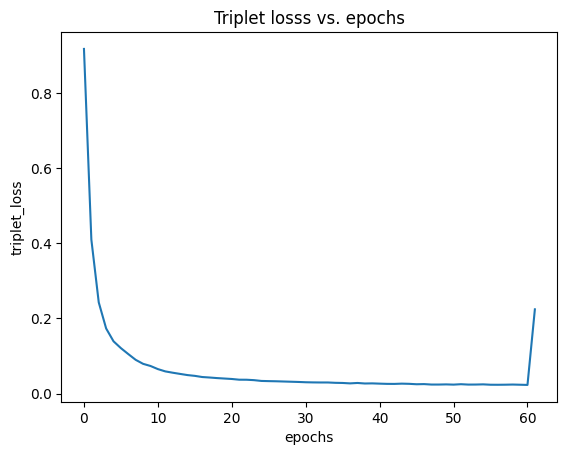

In [ ]:
triplet_loss = [0.9168, 0.4096, 0.2425, 0.1731, 0.1389, 0.1207,
         0.1049, 0.0896, 0.0790, 0.0733, 0.0650, 0.0589,
         0.0554, 0.0522, 0.0491, 0.0470, 0.0439, 0.0426,
         0.0411, 0.0399, 0.0387, 0.0368, 0.0367, 0.0356,
         0.0335, 0.0330, 0.0326, 0.0320, 0.0314, 0.0308,
         0.0300, 0.0296, 0.0294, 0.0294, 0.0285, 0.0281,
         0.0270, 0.0281, 0.0267, 0.0270, 0.0263, 0.0257,
         0.0256, 0.0263, 0.0258, 0.0247, 0.0251, 0.0239,
         0.0239, 0.0243, 0.0237, 0.0248, 0.0238, 0.0239,
         0.0244, 0.0234, 0.0233, 0.0235, 0.0239, 0.0234,
         0.0229, 0.224]

print_epochs = range(0, len(triplet_loss))
plt.plot(print_epochs, triplet_loss)
plt.xlabel("epochs", fontsize = 10)
plt.ylabel("triplet_loss", fontsize = 10)
plt.title("Triplet losss vs. epochs")
plt.savefig("triplet_loss.eps", dpi = 300)

Release GPU

In [ ]:
import gc
gc.collect() # Python thing
# torch.cuda.empty_cache() # PyTorch thing
with torch.no_grad():
    torch.cuda.empty_cache()

Set node features with anchor

In [ ]:
data.x = gnn_pretrain_embed

In [ ]:
data.x = data.x.detach()

In [ ]:
gnn_rel_embed = gnn_rel_embed.detach()

TransE with rel

In [ ]:
import torch.nn.init as init

class GNNPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_gnn_layers, dropout):
        super(GNNPredictor, self).__init__()
        self.dropout = dropout

        self.rel_emb = nn.Parameter(torch.empty(dataset.num_relations, hidden_dim))
        init.xavier_uniform_(self.rel_emb)
        self.lin = nn.Linear(hidden_dim, hidden_dim)

    def decoder(self, head_idx, rel_type, tail_idx):
        self.node_emb = F.relu(self.lin(data.x))
        # self.node_emb = data.x
        head = self.node_emb[head_idx]
        tail = self.node_emb[tail_idx]
        rel = self.rel_emb[rel_type]
        head = F.normalize(head, p=1, dim=1)
        tail = F.normalize(tail, p=1, dim=1)
        return -((head + rel) - tail).norm(p=1, dim=1).view(-1,1)
        # return torch.sum(head * rel * tail, dim=1)
    def forward(self, pos_edge_index, neg_edge_index, edge_type):
        return self.decoder(pos_edge_index[0], edge_type, pos_edge_index[1]), self.decoder(neg_edge_index[0], edge_type, neg_edge_index[1])

    @torch.no_grad()
    def eval_metrics(self, eval_data, k=10):
        # https://github.com/pyg-team/pytorch_geometric/blob/ea2ab705716f02396b074cb1c6175b9224a3bf79/torch_geometric/nn/kge/base.py
        # https://github.com/pyg-team/pytorch_geometric/blob/ea2ab705716f02396b074cb1c6175b9224a3bf79/examples/kge_fb15k_237.py
        head_idx, rel_type, tail_idx = eval_data.edge_index[0].to("cuda"), eval_data.edge_type.to("cuda"), eval_data.edge_index[1].to("cuda")

        reciprocal_ranks, hits_at_k = [], []
        for i in range(rel_type.shape[0]):
            h, r, t = head_idx[i], rel_type[i], tail_idx[i]
            all_tails = torch.arange(data.num_nodes, device="cuda")
            scores = self.decoder(h.expand_as(all_tails), r.expand_as(all_tails), all_tails).view(-1)
            rank = int((scores.argsort(descending=True) == t).nonzero().view(-1))
            reciprocal_ranks.append(1 / (rank + 1))
            hits_at_k.append(rank < k)

        mrr = float(torch.tensor(reciprocal_ranks, dtype=torch.float).mean())
        hits_at_k = int(torch.tensor(hits_at_k).sum()) / len(hits_at_k)
        return mrr, hits_at_k

# negative sampling
def process_data(train_data):
    train_data = train_data.to("cuda")
    mask_1 = torch.rand(train_data.edge_index.size(1)) < 0.5
    mask_2 = ~mask_1

    neg_edge_index = train_data.edge_index.clone()
    neg_edge_index[0, mask_1] = torch.randint(train_data.num_nodes, (mask_1.sum(),), device=neg_edge_index.device)
    neg_edge_index[1, mask_2] = torch.randint(train_data.num_nodes, (mask_2.sum(),), device=neg_edge_index.device)
    return train_data.edge_index, neg_edge_index

def use_gnn(seed, hidden_dim, num_gnn_layers, dropout, lr, reg_coeff):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    gnn_model = GNNPredictor(input_dim=data.num_nodes,
                             hidden_dim=hidden_dim,
                             num_gnn_layers=num_gnn_layers,
                             dropout=dropout).to("cuda")

    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr)
    val_mrr, val_hits_at_k = 0, 0
    test_mrr, test_hits_at_k = 0, 0

    # train
    best_val_mrr = 0
    best_val_hits = 0
    best_test_mrr = 0
    best_test_hits = 0
    for epoch in range(400):
        gnn_model.train()
        optimizer.zero_grad()

        # data
        pos_edge_index, neg_edge_index = process_data(train_data)

        # loss
        pos_edge_pred, neg_edge_pred = gnn_model(pos_edge_index, neg_edge_index, train_data.edge_type)


        out = torch.cat([pos_edge_pred, neg_edge_pred])
        gt = torch.cat([torch.ones_like(pos_edge_pred), torch.zeros_like(neg_edge_pred)])
        loss = F.binary_cross_entropy_with_logits(out, gt)

        # loss = F.margin_ranking_loss(pos_edge_pred, neg_edge_pred, target=torch.ones_like(pos_edge_pred), margin=1)
        reg_loss = gnn_model.node_emb.pow(2).mean() +  gnn_model.rel_emb.pow(2).mean()
        loss = loss + reg_coeff * reg_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gnn_model.parameters(), 1.)
        optimizer.step()

        # valid
        if (epoch + 1) % 10 == 0:
            gnn_model.eval()
            val_mrr, val_hits_at_k = gnn_model.eval_metrics(val_data)
            test_mrr, test_hits_at_k = gnn_model.eval_metrics(test_data)
            print("Epoch: {}\tValidation MRR: {:.4f}\tH@10: {:.4f}\tTest MRR: {:.4f}\tH@10: {:.4f}".format(epoch + 1, val_mrr, val_hits_at_k, test_mrr, test_hits_at_k))

            if val_hits_at_k > best_val_hits:
                best_val_mrr = val_mrr
                best_val_hits = val_hits_at_k
                best_test_mrr = test_mrr
                best_test_hits = test_hits_at_k

    return best_val_mrr, best_val_hits, best_test_mrr, best_test_hits

# example of running with fixed parameters
hidden_dim = 64
num_gnn_layers = 2
seed_list = [14504]
reg_coeff = 1e-2
dropout = 0
lr = 0.01


num_runs = len(seed_list)
for run in range(num_runs):
    print("### Run: {}".format(run + 1))
    best_val_mrr, best_val_hits, best_test_mrr, best_test_hits = use_gnn(seed=seed_list[run],
                                                                         hidden_dim=hidden_dim,
                                                                         num_gnn_layers=num_gnn_layers,
                                                                         dropout=dropout,
                                                                         lr=lr,
                                                                         reg_coeff=reg_coeff)

print("===========Best Results==========")
# print("hidden_dim: {}".format())
print("Validation MRR: {}".format(best_val_mrr))
print("Validation H@10: {}".format(best_val_hits))
print("Test MRR: {}".format(best_test_mrr))
print("Test H@10: {}".format(best_test_hits))

2. DistMult with rel

In [ ]:
from tqdm import tqdm
from torch_geometric.data import Data
class CLRGCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_gnn_layers, dropout):
        super(CLRGCN, self).__init__()

        # anchor
        self.input_emb = nn.Parameter(torch.empty(input_dim, hidden_dim))
        self.rel_emb = nn.Parameter(torch.empty(dataset.num_relations, hidden_dim))
        init.xavier_uniform_(self.input_emb)
        init.xavier_uniform_(self.rel_emb)
        self.gnn_layers = nn.ModuleList()
        self.dropout = dropout
        for _ in range(num_gnn_layers):
            self.gnn_layers.append(pyg_nn.RGCNConv(hidden_dim, hidden_dim, dataset.num_relations*2,  bias=False))

    def forward(self, edge_index, edge_type, anchor, positive, negative, rel_types):

        for i, layer in enumerate(self.gnn_layers):
          if i == 0:
            x = layer(self.input_emb, edge_index, edge_type)
          else:
            x = layer(x, edge_index, edge_type)

          if i < len(self.gnn_layers) - 1:
              x = F.relu(x)
              # x = F.dropout(x, p=self.dropout, training=self.training)
        self.embed = x
        return x[anchor[:, 0]] * self.rel_emb[rel_types] * x[anchor[:, 1]], x[positive[:, 0]] * self.rel_emb[rel_types] * x[positive[:, 1]], x[negative[:, 0]] * self.rel_emb[rel_types] * x[negative[:, 1]]

    @torch.no_grad()
    def eval_infoNCE(self, eval, gnn_model, sample_size):

        ans, edge_type_max  = edge_types_to_groups(eval.edge_type, eval.edge_index)
        anchors, positives, negatives, rel_types = sample_triplets(ans, edge_type_max, sample_size)
        anchors = torch.stack(anchors, dim=0)
        positives = torch.stack(positives, dim=0)
        negatives = torch.stack(negatives, dim=0)
        anchor, positive, negative = gnn_model(eval.edge_index, eval.edge_type, anchors, positives, negatives)
        loss = nn.TripletMarginLoss()
        loss = loss(anchor, positive, negative)
        return loss

def use_gnn(seed, hidden_dim, num_gnn_layers, dropout, lr, epochs, sample_size, train_data, val_data, test_data):
    # seed
    torch.manual_seed(seed)
    train_data = train_data.to("cuda")
    val_data = val_data.to("cuda")
    test_data = test_data.to("cuda")

    gnn_model = CLRGCN(input_dim=data.num_nodes,
                       hidden_dim=hidden_dim,
                       num_gnn_layers=num_gnn_layers,
                       dropout=dropout).to("cuda")
    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr)
    val_mrr, val_hits_at_k = 0, 0
    test_mrr, test_hits_at_k = 0, 0

    total_edge_index = train_data.edge_index
    total_edge_types = train_data.edge_type

    ans, edge_type_max  = edge_types_to_groups(total_edge_types, total_edge_index)

    # train
    for epoch in tqdm(range(epochs)):

        gnn_model.train()
        optimizer.zero_grad()
        anchors, positives, negatives, rel_types = sample_triplets(ans, edge_type_max, sample_size)
        anchors = torch.stack(anchors, dim=0).to("cuda")
        positives = torch.stack(positives, dim=0).to("cuda")
        negatives = torch.stack(negatives, dim=0).to("cuda")

        # contrastive loss: Tripletloss
        anchor, positive, negative = gnn_model(total_edge_index, total_edge_types, anchors, positives, negatives, rel_types)

        loss = nn.TripletMarginLoss()
        loss = loss(anchor, positive, negative)
        print(loss)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gnn_model.parameters(), 1.)
        optimizer.step()

    return val_mrr, val_hits_at_k, test_mrr, test_hits_at_k, anchor, positive, negative, gnn_model.embed, gnn_model.rel_emb

In [ ]:
# Hyperparameters
hidden_dim = 64
num_gnn_layers = 2
seed = 0
dropout = 0.2
lr = 0.01
epochs = 100
sample_size = 1
val_mrr, val_hits_at_k, test_mrr, test_hits_at_k, anchor, positive, negative, gnn_pretrain_embed, gnn_rel_embed = use_gnn(seed=seed, hidden_dim=hidden_dim,
                                                          num_gnn_layers=num_gnn_layers,
                                                          dropout=dropout,
                                                          lr=lr,
                                                          epochs = epochs,
                                                          sample_size = sample_size,
                                                          train_data = train_data,
                                                          val_data = val_data,
                                                          test_data = test_data)


  0%|          | 0/100 [00:00<?, ?it/s]

tensor(0.9998, device='cuda:0', grad_fn=<MeanBackward0>)


  1%|          | 1/100 [00:58<1:36:46, 58.66s/it]

tensor(0.9677, device='cuda:0', grad_fn=<MeanBackward0>)


  2%|▏         | 2/100 [02:01<1:39:46, 61.08s/it]

tensor(0.7970, device='cuda:0', grad_fn=<MeanBackward0>)


  3%|▎         | 3/100 [03:00<1:37:19, 60.21s/it]

tensor(0.6389, device='cuda:0', grad_fn=<MeanBackward0>)


  4%|▍         | 4/100 [03:59<1:35:27, 59.67s/it]

tensor(0.4668, device='cuda:0', grad_fn=<MeanBackward0>)


  5%|▌         | 5/100 [05:04<1:37:21, 61.49s/it]

tensor(0.3127, device='cuda:0', grad_fn=<MeanBackward0>)


  6%|▌         | 6/100 [06:03<1:35:00, 60.64s/it]

tensor(0.2355, device='cuda:0', grad_fn=<MeanBackward0>)


  7%|▋         | 7/100 [07:03<1:33:39, 60.42s/it]

tensor(0.1889, device='cuda:0', grad_fn=<MeanBackward0>)


  8%|▊         | 8/100 [08:01<1:31:34, 59.73s/it]

tensor(0.1427, device='cuda:0', grad_fn=<MeanBackward0>)


  9%|▉         | 9/100 [09:00<1:30:26, 59.63s/it]

tensor(0.1154, device='cuda:0', grad_fn=<MeanBackward0>)


 10%|█         | 10/100 [09:59<1:29:00, 59.34s/it]

tensor(0.0940, device='cuda:0', grad_fn=<MeanBackward0>)


 11%|█         | 11/100 [10:58<1:27:50, 59.22s/it]

tensor(0.0796, device='cuda:0', grad_fn=<MeanBackward0>)


 12%|█▏        | 12/100 [11:58<1:27:05, 59.38s/it]

tensor(0.0656, device='cuda:0', grad_fn=<MeanBackward0>)


 13%|█▎        | 13/100 [12:57<1:26:06, 59.38s/it]

tensor(0.0548, device='cuda:0', grad_fn=<MeanBackward0>)


 14%|█▍        | 14/100 [13:57<1:25:08, 59.40s/it]

tensor(0.0483, device='cuda:0', grad_fn=<MeanBackward0>)


 15%|█▌        | 15/100 [14:55<1:23:57, 59.26s/it]

tensor(0.0427, device='cuda:0', grad_fn=<MeanBackward0>)


 16%|█▌        | 16/100 [15:55<1:23:07, 59.38s/it]

tensor(0.0393, device='cuda:0', grad_fn=<MeanBackward0>)


 17%|█▋        | 17/100 [16:54<1:21:56, 59.23s/it]

tensor(0.0359, device='cuda:0', grad_fn=<MeanBackward0>)


 18%|█▊        | 18/100 [17:54<1:21:08, 59.37s/it]

tensor(0.0340, device='cuda:0', grad_fn=<MeanBackward0>)


 19%|█▉        | 19/100 [18:53<1:19:59, 59.25s/it]

tensor(0.0303, device='cuda:0', grad_fn=<MeanBackward0>)


 20%|██        | 20/100 [19:52<1:19:04, 59.30s/it]

tensor(0.0279, device='cuda:0', grad_fn=<MeanBackward0>)


 21%|██        | 21/100 [20:51<1:18:04, 59.30s/it]

tensor(0.0260, device='cuda:0', grad_fn=<MeanBackward0>)


 22%|██▏       | 22/100 [21:50<1:17:01, 59.25s/it]

tensor(0.0240, device='cuda:0', grad_fn=<MeanBackward0>)


 23%|██▎       | 23/100 [22:51<1:16:19, 59.48s/it]

tensor(0.0219, device='cuda:0', grad_fn=<MeanBackward0>)


 24%|██▍       | 24/100 [23:50<1:15:15, 59.42s/it]

tensor(0.0205, device='cuda:0', grad_fn=<MeanBackward0>)


 25%|██▌       | 25/100 [24:50<1:14:25, 59.54s/it]

tensor(0.0197, device='cuda:0', grad_fn=<MeanBackward0>)


 26%|██▌       | 26/100 [25:49<1:13:20, 59.47s/it]

tensor(0.0187, device='cuda:0', grad_fn=<MeanBackward0>)


 27%|██▋       | 27/100 [26:49<1:12:30, 59.60s/it]

tensor(0.0180, device='cuda:0', grad_fn=<MeanBackward0>)


 28%|██▊       | 28/100 [27:48<1:11:19, 59.44s/it]

tensor(0.0168, device='cuda:0', grad_fn=<MeanBackward0>)


 29%|██▉       | 29/100 [28:48<1:10:26, 59.53s/it]

tensor(0.0160, device='cuda:0', grad_fn=<MeanBackward0>)


 30%|███       | 30/100 [29:47<1:09:21, 59.45s/it]

tensor(0.0164, device='cuda:0', grad_fn=<MeanBackward0>)


 31%|███       | 31/100 [30:46<1:08:25, 59.49s/it]

tensor(0.0163, device='cuda:0', grad_fn=<MeanBackward0>)


 32%|███▏      | 32/100 [31:46<1:07:15, 59.35s/it]

tensor(0.0146, device='cuda:0', grad_fn=<MeanBackward0>)


 33%|███▎      | 33/100 [32:45<1:06:29, 59.54s/it]

tensor(0.0148, device='cuda:0', grad_fn=<MeanBackward0>)


 34%|███▍      | 34/100 [33:45<1:05:26, 59.49s/it]

tensor(0.0143, device='cuda:0', grad_fn=<MeanBackward0>)


 35%|███▌      | 35/100 [34:45<1:04:36, 59.64s/it]

tensor(0.0142, device='cuda:0', grad_fn=<MeanBackward0>)


 36%|███▌      | 36/100 [35:44<1:03:25, 59.45s/it]

tensor(0.0137, device='cuda:0', grad_fn=<MeanBackward0>)


 37%|███▋      | 37/100 [36:44<1:02:33, 59.57s/it]

tensor(0.0126, device='cuda:0', grad_fn=<MeanBackward0>)


 38%|███▊      | 38/100 [37:43<1:01:21, 59.38s/it]

tensor(0.0127, device='cuda:0', grad_fn=<MeanBackward0>)


 39%|███▉      | 39/100 [38:52<1:03:30, 62.46s/it]

tensor(0.0124, device='cuda:0', grad_fn=<MeanBackward0>)


 40%|████      | 40/100 [40:00<1:03:56, 63.94s/it]

tensor(0.0122, device='cuda:0', grad_fn=<MeanBackward0>)


 41%|████      | 41/100 [41:00<1:01:44, 62.80s/it]

tensor(0.0122, device='cuda:0', grad_fn=<MeanBackward0>)


 42%|████▏     | 42/100 [42:00<59:49, 61.89s/it]  

tensor(0.0115, device='cuda:0', grad_fn=<MeanBackward0>)


 43%|████▎     | 43/100 [43:00<58:19, 61.39s/it]

tensor(0.0111, device='cuda:0', grad_fn=<MeanBackward0>)


 44%|████▍     | 44/100 [43:59<56:46, 60.83s/it]

tensor(0.0115, device='cuda:0', grad_fn=<MeanBackward0>)


 45%|████▌     | 45/100 [44:59<55:32, 60.59s/it]

tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>)


 46%|████▌     | 46/100 [45:58<54:06, 60.12s/it]

tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>)


 47%|████▋     | 47/100 [46:58<52:59, 60.00s/it]

tensor(0.0108, device='cuda:0', grad_fn=<MeanBackward0>)


 48%|████▊     | 48/100 [47:57<51:48, 59.77s/it]

tensor(0.0106, device='cuda:0', grad_fn=<MeanBackward0>)


 49%|████▉     | 49/100 [48:57<50:44, 59.69s/it]

tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>)


 50%|█████     | 50/100 [49:56<49:43, 59.66s/it]

tensor(0.0107, device='cuda:0', grad_fn=<MeanBackward0>)


 51%|█████     | 51/100 [50:56<48:36, 59.52s/it]

tensor(0.0102, device='cuda:0', grad_fn=<MeanBackward0>)


 52%|█████▏    | 52/100 [51:55<47:39, 59.56s/it]

tensor(0.0097, device='cuda:0', grad_fn=<MeanBackward0>)


 53%|█████▎    | 53/100 [52:55<46:34, 59.46s/it]

tensor(0.0101, device='cuda:0', grad_fn=<MeanBackward0>)


 54%|█████▍    | 54/100 [53:54<45:39, 59.55s/it]

tensor(0.0099, device='cuda:0', grad_fn=<MeanBackward0>)


 55%|█████▌    | 55/100 [54:54<44:37, 59.49s/it]

tensor(0.0097, device='cuda:0', grad_fn=<MeanBackward0>)


 56%|█████▌    | 56/100 [55:53<43:41, 59.57s/it]

tensor(0.0098, device='cuda:0', grad_fn=<MeanBackward0>)


 57%|█████▋    | 57/100 [56:53<42:38, 59.49s/it]

tensor(0.0094, device='cuda:0', grad_fn=<MeanBackward0>)


 58%|█████▊    | 58/100 [57:53<41:49, 59.74s/it]

tensor(0.0096, device='cuda:0', grad_fn=<MeanBackward0>)


 59%|█████▉    | 59/100 [58:53<40:47, 59.69s/it]

tensor(0.0091, device='cuda:0', grad_fn=<MeanBackward0>)


 60%|██████    | 60/100 [59:52<39:47, 59.69s/it]

tensor(0.0094, device='cuda:0', grad_fn=<MeanBackward0>)


 61%|██████    | 61/100 [1:00:52<38:42, 59.55s/it]

tensor(0.0094, device='cuda:0', grad_fn=<MeanBackward0>)


 62%|██████▏   | 62/100 [1:01:51<37:41, 59.51s/it]

tensor(0.0092, device='cuda:0', grad_fn=<MeanBackward0>)


 63%|██████▎   | 63/100 [1:02:50<36:41, 59.50s/it]

tensor(0.0089, device='cuda:0', grad_fn=<MeanBackward0>)


 64%|██████▍   | 64/100 [1:03:50<35:45, 59.60s/it]

tensor(0.0090, device='cuda:0', grad_fn=<MeanBackward0>)


 65%|██████▌   | 65/100 [1:04:49<34:41, 59.47s/it]

tensor(0.0087, device='cuda:0', grad_fn=<MeanBackward0>)


 66%|██████▌   | 66/100 [1:05:49<33:47, 59.64s/it]

tensor(0.0088, device='cuda:0', grad_fn=<MeanBackward0>)


 67%|██████▋   | 67/100 [1:06:49<32:44, 59.53s/it]

tensor(0.0087, device='cuda:0', grad_fn=<MeanBackward0>)


 68%|██████▊   | 68/100 [1:07:49<31:49, 59.66s/it]

tensor(0.0089, device='cuda:0', grad_fn=<MeanBackward0>)


 69%|██████▉   | 69/100 [1:08:48<30:45, 59.53s/it]

tensor(0.0085, device='cuda:0', grad_fn=<MeanBackward0>)


 70%|███████   | 70/100 [1:09:48<29:49, 59.66s/it]

tensor(0.0092, device='cuda:0', grad_fn=<MeanBackward0>)


 71%|███████   | 71/100 [1:10:47<28:47, 59.57s/it]

tensor(0.0087, device='cuda:0', grad_fn=<MeanBackward0>)


 72%|███████▏  | 72/100 [1:11:47<27:46, 59.52s/it]

tensor(0.0086, device='cuda:0', grad_fn=<MeanBackward0>)


 73%|███████▎  | 73/100 [1:12:47<26:56, 59.89s/it]

tensor(0.0085, device='cuda:0', grad_fn=<MeanBackward0>)


 74%|███████▍  | 74/100 [1:13:47<25:56, 59.88s/it]

tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)


 75%|███████▌  | 75/100 [1:14:47<24:57, 59.92s/it]

tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)


 76%|███████▌  | 76/100 [1:15:47<23:56, 59.83s/it]

tensor(0.0081, device='cuda:0', grad_fn=<MeanBackward0>)


 77%|███████▋  | 77/100 [1:16:47<22:55, 59.79s/it]

tensor(0.0083, device='cuda:0', grad_fn=<MeanBackward0>)


 78%|███████▊  | 78/100 [1:17:46<21:51, 59.60s/it]

tensor(0.0086, device='cuda:0', grad_fn=<MeanBackward0>)


 79%|███████▉  | 79/100 [1:18:46<20:54, 59.72s/it]

tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>)


 80%|████████  | 80/100 [1:19:45<19:50, 59.50s/it]

tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>)


 81%|████████  | 81/100 [1:20:45<18:53, 59.67s/it]

tensor(0.0079, device='cuda:0', grad_fn=<MeanBackward0>)


 82%|████████▏ | 82/100 [1:21:44<17:51, 59.54s/it]

tensor(0.0080, device='cuda:0', grad_fn=<MeanBackward0>)


 83%|████████▎ | 83/100 [1:22:44<16:55, 59.75s/it]

tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>)


 84%|████████▍ | 84/100 [1:23:44<15:53, 59.61s/it]

tensor(0.0081, device='cuda:0', grad_fn=<MeanBackward0>)


 85%|████████▌ | 85/100 [1:24:44<14:56, 59.75s/it]

tensor(0.0084, device='cuda:0', grad_fn=<MeanBackward0>)


 86%|████████▌ | 86/100 [1:25:43<13:56, 59.73s/it]

tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>)


 87%|████████▋ | 87/100 [1:26:43<12:55, 59.69s/it]

tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>)


 88%|████████▊ | 88/100 [1:27:42<11:54, 59.51s/it]

tensor(0.0082, device='cuda:0', grad_fn=<MeanBackward0>)


 89%|████████▉ | 89/100 [1:28:42<10:55, 59.58s/it]

tensor(0.0079, device='cuda:0', grad_fn=<MeanBackward0>)


 90%|█████████ | 90/100 [1:29:41<09:54, 59.45s/it]

tensor(0.0076, device='cuda:0', grad_fn=<MeanBackward0>)


 91%|█████████ | 91/100 [1:30:41<08:56, 59.62s/it]

tensor(0.0076, device='cuda:0', grad_fn=<MeanBackward0>)


 92%|█████████▏| 92/100 [1:31:40<07:56, 59.54s/it]

tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>)


 93%|█████████▎| 93/100 [1:32:41<06:58, 59.82s/it]

tensor(0.0077, device='cuda:0', grad_fn=<MeanBackward0>)


 94%|█████████▍| 94/100 [1:33:40<05:58, 59.69s/it]

tensor(0.0078, device='cuda:0', grad_fn=<MeanBackward0>)


 95%|█████████▌| 95/100 [1:34:40<04:58, 59.79s/it]

tensor(0.0076, device='cuda:0', grad_fn=<MeanBackward0>)


 96%|█████████▌| 96/100 [1:35:39<03:58, 59.61s/it]

tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>)


 97%|█████████▋| 97/100 [1:36:40<02:59, 59.80s/it]

tensor(0.0073, device='cuda:0', grad_fn=<MeanBackward0>)


 98%|█████████▊| 98/100 [1:37:38<01:59, 59.52s/it]

tensor(0.0076, device='cuda:0', grad_fn=<MeanBackward0>)


 99%|█████████▉| 99/100 [1:38:38<00:59, 59.65s/it]

tensor(0.0074, device='cuda:0', grad_fn=<MeanBackward0>)


100%|██████████| 100/100 [1:39:38<00:00, 59.78s/it]


Release GPU

In [ ]:
import gc
gc.collect() # Python thing
# torch.cuda.empty_cache() # PyTorch thing
with torch.no_grad():
    torch.cuda.empty_cache()

In [ ]:
data.x = gnn_pretrain_embed

In [ ]:
data.x = data.x.detach()

In [ ]:
gnn_rel_embed = gnn_rel_embed.detach()

 TransE Decoder

In [ ]:
import torch.nn.init as init

class GNNPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_gnn_layers, dropout):
        super(GNNPredictor, self).__init__()
        self.dropout = dropout

        self.rel_emb = nn.Parameter(torch.empty(dataset.num_relations, hidden_dim))
        init.xavier_uniform_(self.rel_emb)
        self.lin = nn.Linear(hidden_dim, hidden_dim)

    def decoder(self, head_idx, rel_type, tail_idx):
        self.node_emb = F.relu(self.lin(data.x))
        # self.node_emb = data.x
        head = self.node_emb[head_idx]
        tail = self.node_emb[tail_idx]
        rel = self.rel_emb[rel_type]
        head = F.normalize(head, p=1, dim=1)
        tail = F.normalize(tail, p=1, dim=1)
        return -((head + rel) - tail).norm(p=1, dim=1).view(-1,1)
        # return torch.sum(head * rel * tail, dim=1)
    def forward(self, pos_edge_index, neg_edge_index, edge_type):
        return self.decoder(pos_edge_index[0], edge_type, pos_edge_index[1]), self.decoder(neg_edge_index[0], edge_type, neg_edge_index[1])

    @torch.no_grad()
    def eval_metrics(self, eval_data, k=10):
        # https://github.com/pyg-team/pytorch_geometric/blob/ea2ab705716f02396b074cb1c6175b9224a3bf79/torch_geometric/nn/kge/base.py
        # https://github.com/pyg-team/pytorch_geometric/blob/ea2ab705716f02396b074cb1c6175b9224a3bf79/examples/kge_fb15k_237.py
        head_idx, rel_type, tail_idx = eval_data.edge_index[0].to("cuda"), eval_data.edge_type.to("cuda"), eval_data.edge_index[1].to("cuda")

        reciprocal_ranks, hits_at_k = [], []
        for i in range(rel_type.shape[0]):
            h, r, t = head_idx[i], rel_type[i], tail_idx[i]
            all_tails = torch.arange(data.num_nodes, device="cuda")
            scores = self.decoder(h.expand_as(all_tails), r.expand_as(all_tails), all_tails).view(-1)
            rank = int((scores.argsort(descending=True) == t).nonzero().view(-1))
            reciprocal_ranks.append(1 / (rank + 1))
            hits_at_k.append(rank < k)

        mrr = float(torch.tensor(reciprocal_ranks, dtype=torch.float).mean())
        hits_at_k = int(torch.tensor(hits_at_k).sum()) / len(hits_at_k)
        return mrr, hits_at_k

# negative sampling
def process_data(train_data):
    train_data = train_data.to("cuda")
    mask_1 = torch.rand(train_data.edge_index.size(1)) < 0.5
    mask_2 = ~mask_1

    neg_edge_index = train_data.edge_index.clone()
    neg_edge_index[0, mask_1] = torch.randint(train_data.num_nodes, (mask_1.sum(),), device=neg_edge_index.device)
    neg_edge_index[1, mask_2] = torch.randint(train_data.num_nodes, (mask_2.sum(),), device=neg_edge_index.device)
    return train_data.edge_index, neg_edge_index

def use_gnn(seed, hidden_dim, num_gnn_layers, dropout, lr, reg_coeff):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    gnn_model = GNNPredictor(input_dim=data.num_nodes,
                             hidden_dim=hidden_dim,
                             num_gnn_layers=num_gnn_layers,
                             dropout=dropout).to("cuda")

    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr)
    val_mrr, val_hits_at_k = 0, 0
    test_mrr, test_hits_at_k = 0, 0

    # train
    best_val_mrr = 0
    best_val_hits = 0
    best_test_mrr = 0
    best_test_hits = 0
    for epoch in range(400):
        gnn_model.train()
        optimizer.zero_grad()

        # data
        pos_edge_index, neg_edge_index = process_data(train_data)

        # loss
        pos_edge_pred, neg_edge_pred = gnn_model(pos_edge_index, neg_edge_index, train_data.edge_type)


        out = torch.cat([pos_edge_pred, neg_edge_pred])
        gt = torch.cat([torch.ones_like(pos_edge_pred), torch.zeros_like(neg_edge_pred)])
        loss = F.binary_cross_entropy_with_logits(out, gt)

        # loss = F.margin_ranking_loss(pos_edge_pred, neg_edge_pred, target=torch.ones_like(pos_edge_pred), margin=1)
        reg_loss = gnn_model.node_emb.pow(2).mean() +  gnn_model.rel_emb.pow(2).mean()
        loss = loss + reg_coeff * reg_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gnn_model.parameters(), 1.)
        optimizer.step()

        # valid
        if (epoch + 1) % 10 == 0:
            gnn_model.eval()
            val_mrr, val_hits_at_k = gnn_model.eval_metrics(val_data)
            test_mrr, test_hits_at_k = gnn_model.eval_metrics(test_data)
            print("Epoch: {}\tValidation MRR: {:.4f}\tH@10: {:.4f}\tTest MRR: {:.4f}\tH@10: {:.4f}".format(epoch + 1, val_mrr, val_hits_at_k, test_mrr, test_hits_at_k))

            if val_hits_at_k > best_val_hits:
                best_val_mrr = val_mrr
                best_val_hits = val_hits_at_k
                best_test_mrr = test_mrr
                best_test_hits = test_hits_at_k

    return best_val_mrr, best_val_hits, best_test_mrr, best_test_hits

# example of running with fixed parameters
hidden_dim = 64
num_gnn_layers = 2
seed_list = [14504]
reg_coeff = 1e-2
dropout = 0
lr = 0.01


num_runs = len(seed_list)
for run in range(num_runs):
    print("### Run: {}".format(run + 1))
    best_val_mrr, best_val_hits, best_test_mrr, best_test_hits = use_gnn(seed=seed_list[run],
                                                                         hidden_dim=hidden_dim,
                                                                         num_gnn_layers=num_gnn_layers,
                                                                         dropout=dropout,
                                                                         lr=lr,
                                                                         reg_coeff=reg_coeff)

print("===========Best Results==========")
# print("hidden_dim: {}".format())
print("Validation MRR: {}".format(best_val_mrr))
print("Validation H@10: {}".format(best_val_hits))
print("Test MRR: {}".format(best_test_mrr))
print("Test H@10: {}".format(best_test_hits))

DistMult Decoder

In [ ]:
import torch.nn.init as init

class GNNPredictor(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_gnn_layers, dropout):
        super(GNNPredictor, self).__init__()
        self.dropout = dropout

        self.rel_emb = nn.Parameter(torch.empty(dataset.num_relations, hidden_dim))
        init.xavier_uniform_(self.rel_emb)
        self.lin = nn.Linear(hidden_dim, hidden_dim)

    def decoder(self, head_idx, rel_type, tail_idx):
        self.node_emb = F.relu(self.lin(data.x))
        # self.node_emb = data.x
        head = self.node_emb[head_idx]
        tail = self.node_emb[tail_idx]
        rel = self.rel_emb[rel_type]
        # head = F.normalize(head, p=1, dim=1)
        # tail = F.normalize(tail, p=1, dim=1)
        # return -((head + rel) - tail).norm(p=1, dim=1).view(-1,1)
        return torch.sum(head * rel * tail, dim=1)
    def forward(self, pos_edge_index, neg_edge_index, edge_type):
        return self.decoder(pos_edge_index[0], edge_type, pos_edge_index[1]), self.decoder(neg_edge_index[0], edge_type, neg_edge_index[1])

    @torch.no_grad()
    def eval_metrics(self, eval_data, k=10):
        # https://github.com/pyg-team/pytorch_geometric/blob/ea2ab705716f02396b074cb1c6175b9224a3bf79/torch_geometric/nn/kge/base.py
        # https://github.com/pyg-team/pytorch_geometric/blob/ea2ab705716f02396b074cb1c6175b9224a3bf79/examples/kge_fb15k_237.py
        head_idx, rel_type, tail_idx = eval_data.edge_index[0].to("cuda"), eval_data.edge_type.to("cuda"), eval_data.edge_index[1].to("cuda")

        reciprocal_ranks, hits_at_k = [], []
        for i in range(rel_type.shape[0]):
            h, r, t = head_idx[i], rel_type[i], tail_idx[i]
            all_tails = torch.arange(data.num_nodes, device="cuda")
            scores = self.decoder(h.expand_as(all_tails), r.expand_as(all_tails), all_tails).view(-1)
            rank = int((scores.argsort(descending=True) == t).nonzero().view(-1))
            reciprocal_ranks.append(1 / (rank + 1))
            hits_at_k.append(rank < k)

        mrr = float(torch.tensor(reciprocal_ranks, dtype=torch.float).mean())
        hits_at_k = int(torch.tensor(hits_at_k).sum()) / len(hits_at_k)
        return mrr, hits_at_k

# negative sampling
def process_data(train_data):
    train_data = train_data.to("cuda")
    mask_1 = torch.rand(train_data.edge_index.size(1)) < 0.5
    mask_2 = ~mask_1

    neg_edge_index = train_data.edge_index.clone()
    neg_edge_index[0, mask_1] = torch.randint(train_data.num_nodes, (mask_1.sum(),), device=neg_edge_index.device)
    neg_edge_index[1, mask_2] = torch.randint(train_data.num_nodes, (mask_2.sum(),), device=neg_edge_index.device)
    return train_data.edge_index, neg_edge_index

def use_gnn(seed, hidden_dim, num_gnn_layers, dropout, lr, reg_coeff):
    # seed
    torch.manual_seed(seed)

    # model and optimizer
    gnn_model = GNNPredictor(input_dim=data.num_nodes,
                             hidden_dim=hidden_dim,
                             num_gnn_layers=num_gnn_layers,
                             dropout=dropout).to("cuda")

    optimizer = torch.optim.Adam(gnn_model.parameters(), lr=lr)
    val_mrr, val_hits_at_k = 0, 0
    test_mrr, test_hits_at_k = 0, 0

    # train
    best_val_mrr = 0
    best_val_hits = 0
    best_test_mrr = 0
    best_test_hits = 0
    for epoch in range(400):
        gnn_model.train()
        optimizer.zero_grad()

        # data
        pos_edge_index, neg_edge_index = process_data(train_data)

        # loss
        pos_edge_pred, neg_edge_pred = gnn_model(pos_edge_index, neg_edge_index, train_data.edge_type)


        out = torch.cat([pos_edge_pred, neg_edge_pred])
        gt = torch.cat([torch.ones_like(pos_edge_pred), torch.zeros_like(neg_edge_pred)])
        # loss = F.binary_cross_entropy_with_logits(out, gt)

        loss = F.margin_ranking_loss(pos_edge_pred, neg_edge_pred, target=torch.ones_like(pos_edge_pred), margin=1)
        reg_loss = gnn_model.node_emb.pow(2).mean() +  gnn_model.rel_emb.pow(2).mean()
        loss = loss + reg_coeff * reg_loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(gnn_model.parameters(), 1.)
        optimizer.step()

        # valid
        if (epoch + 1) % 10 == 0:
            gnn_model.eval()
            val_mrr, val_hits_at_k = gnn_model.eval_metrics(val_data)
            test_mrr, test_hits_at_k = gnn_model.eval_metrics(test_data)
            print("Epoch: {}\tValidation MRR: {:.4f}\tH@10: {:.4f}\tTest MRR: {:.4f}\tH@10: {:.4f}".format(epoch + 1, val_mrr, val_hits_at_k, test_mrr, test_hits_at_k))

            if val_hits_at_k > best_val_hits:
                best_val_mrr = val_mrr
                best_val_hits = val_hits_at_k
                best_test_mrr = test_mrr
                best_test_hits = test_hits_at_k

    return best_val_mrr, best_val_hits, best_test_mrr, best_test_hits

# example of running with fixed parameters
hidden_dim = 64
num_gnn_layers = 2
seed_list = [14504]
reg_coeff = 1e-2
dropout = 0
lr = 0.01


num_runs = len(seed_list)
for run in range(num_runs):
    print("### Run: {}".format(run + 1))
    best_val_mrr, best_val_hits, best_test_mrr, best_test_hits = use_gnn(seed=seed_list[run],
                                                                         hidden_dim=hidden_dim,
                                                                         num_gnn_layers=num_gnn_layers,
                                                                         dropout=dropout,
                                                                         lr=lr,
                                                                         reg_coeff=reg_coeff)

print("===========Best Results==========")
# print("hidden_dim: {}".format())
print("Validation MRR: {}".format(best_val_mrr))
print("Validation H@10: {}".format(best_val_hits))
print("Test MRR: {}".format(best_test_mrr))
print("Test H@10: {}".format(best_test_hits))

### Run: 1
Epoch: 10	Validation MRR: 0.0599	H@10: 0.1141	Test MRR: 0.0598	H@10: 0.1158
Epoch: 20	Validation MRR: 0.1147	H@10: 0.1885	Test MRR: 0.1107	H@10: 0.1851
Epoch: 30	Validation MRR: 0.1161	H@10: 0.2001	Test MRR: 0.1141	H@10: 0.1978
Epoch: 40	Validation MRR: 0.1231	H@10: 0.2171	Test MRR: 0.1198	H@10: 0.2121
Epoch: 50	Validation MRR: 0.1248	H@10: 0.2163	Test MRR: 0.1214	H@10: 0.2117
Epoch: 60	Validation MRR: 0.1275	H@10: 0.2246	Test MRR: 0.1242	H@10: 0.2174
Epoch: 70	Validation MRR: 0.1277	H@10: 0.2244	Test MRR: 0.1240	H@10: 0.2177
Epoch: 80	Validation MRR: 0.1308	H@10: 0.2267	Test MRR: 0.1259	H@10: 0.2207
Epoch: 90	Validation MRR: 0.1312	H@10: 0.2267	Test MRR: 0.1274	H@10: 0.2210
Epoch: 100	Validation MRR: 0.1313	H@10: 0.2296	Test MRR: 0.1265	H@10: 0.2245
Epoch: 110	Validation MRR: 0.1324	H@10: 0.2344	Test MRR: 0.1278	H@10: 0.2285
Epoch: 120	Validation MRR: 0.1380	H@10: 0.2466	Test MRR: 0.1342	H@10: 0.2423
Epoch: 130	Validation MRR: 0.1401	H@10: 0.2427	Test MRR: 0.1353	H@10: 0.23